# AUTOMATED ESSAY GRADER

#### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import time

#### Loading the dataset

In [2]:
df = pd.read_excel("train.xlsx")
df = df[['essay_id', 'essay_set', 'essay', 'domain1_score']]
df = df.rename(index=str, columns={"domain1_score": "score"})
df.head()

,essay_id,essay_set,essay,score
0,1,1,"Dear local newspaper, I think effects computer...",8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",8.0


Here is our dataset containing essays(responses) on a certain topic in the essay column. The "score" column contains the scores given to each essay by a human grader. Our motive is to train a machine to predict the scores for the essays.

## Data Cleaning

In [3]:
#removing the essays with set 7 and 8 to make the computation less expensive. Leaving them we have 6 more sets.

df = df[df.essay_set != 7]
df = df[df.essay_set != 8]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10686 entries, 0 to 10685
Data columns (total 4 columns):
essay_id     10686 non-null int64
essay_set    10686 non-null int64
essay        10686 non-null object
score        10685 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 417.4+ KB


We have one null value in the score column. Let's see which value is it.

In [5]:
df[pd.isnull(df).any(axis=1)]

,essay_id,essay_set,essay,score
6973,10534,4,"When they come back, Saeng vowed silently to h...",NaN


In [6]:
#filling the null value
df.fillna(value = 2.0, inplace= True)

Creating different datasets for each essay set. This will help in mixing up the data well.

In [7]:
set1 = df[df['essay_set'] == 1]
set1.head()

,essay_id,essay_set,essay,score
0,1,1,"Dear local newspaper, I think effects computer...",8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",8.0


In [8]:
set2 = df[df['essay_set'] == 2]
set3 = df[df['essay_set'] == 3]
set4 = df[df['essay_set'] == 4]
set5 = df[df['essay_set'] == 5]
set6 = df[df['essay_set'] == 6]

Now we will split the sets in training and testing data and then join them as one.

In [9]:
from sklearn.model_selection import train_test_split
set1_train, set1_test= train_test_split(set1, test_size=0.10, random_state= 1)
set2_train, set2_test= train_test_split(set2, test_size=0.10, random_state= 1)
set3_train, set3_test= train_test_split(set3, test_size=0.10, random_state= 1)
set4_train, set4_test= train_test_split(set4, test_size=0.10, random_state= 1)
set5_train, set5_test= train_test_split(set5, test_size=0.10, random_state= 1)
set6_train, set6_test= train_test_split(set6, test_size=0.10, random_state= 1)

In [10]:
train = pd.concat([set1_train, set2_train, set3_train, set4_train, set5_train, set6_train], axis= 0)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9615 entries, 1123 to 9947
Data columns (total 4 columns):
essay_id     9615 non-null int64
essay_set    9615 non-null int64
essay        9615 non-null object
score        9615 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 375.6+ KB


In [12]:
test = pd.concat([set1_test, set2_test, set3_test, set4_test, set5_test, set6_test], axis= 0)

In [13]:
train['source'] = 'Train'
test['source'] = 'Test'
data = pd.concat([train, test], axis = 0)
data.to_pickle('pickles/minorproject')

In [15]:
#saving the data in the pickle file
data = pd.read_pickle('pickles/minorproject')
data.head()

,essay_id,essay_set,essay,score,source
1123,1126,1,"@ORGANIZATION1, I strongly believe that we nee...",10.0,Train
53,54,1,"Dear Local Newspaper, @CAPS1! I am an @NUM1 gr...",10.0,Train
1659,1664,1,"Dear Local Newspaper, I have been using my com...",8.0,Train
898,901,1,"Dear local news paper, In @CAPS1 oppinion I th...",8.0,Train
602,605,1,"Dear Newspaper @CAPS1, I believe that if you a...",6.0,Train


## Data Preprocessing

In [16]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'yours', 'before', 'further', 'each', 'out', 'and', 'will', 'they', "shouldn't", 'herself', 'y', 'whom', 'against', 'other', 'should', 'having', 'those', 'to', 'ma', 'these', 'than', 'hasn', 'isn', 'off', 'their', 'my', 'don', 'he', 'weren', 'over', 'such', 'our', 'or', 'its', 'didn', 'below', 'does', 'wouldn', 'up', "aren't", 'any', 'about', 'as', 'd', 's', 've', "you'll", 'while', 'so', 'shan', 'being', 'have', 'wasn', "didn't", "wasn't", 'now', 'i', "hasn't", 'how', 'were', 'is', 'hadn', "she's", 'be', 'which', 'her', 'mustn', 'from', 'just', 'on', 'theirs', 'him', 'down', 'when', 'both', 'what', 'shouldn', 'by', 'above', 'myself', 'we', "wouldn't", 'your', "you'd", 'no', 'some', 'has', 'very', 'then', "couldn't", 'but', 'all', 'doesn', 'do', 'after', "mightn't", 'ours', 'yourself', 'll', 'that', 'under', 'nor', 'she', 'it', 'me', 'couldn', 'during', 'if', 'm', 'you', 'once', "should've", 'with', 'through', 'here', 'was', 'for', 'not', 'o', 'them', 'the', 'had', 'why', 'won', 'his'

In [17]:
def nlp_preprocessing(total_text, index, column, dataset):
    if type(total_text) is not int:
        string = ""
        punc = [".", "?", ",", "!", "/", "-", ":", ";", "(", ")", "_"]
        for item in punc:
            total_text = total_text.split(item)
            total_text = " ".join(total_text)
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        dataset[column][index] = string

In [18]:
# we take each title and we text-preprocess it.
def preprocessing(dataset):
    for index, row in dataset.iterrows():
        nlp_preprocessing(row['essay'], index, 'essay', dataset)

In [19]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [20]:
preprocessing(data)

In [21]:
data.to_pickle('pickles/minorproject')

In [22]:
data = pd.read_pickle('pickles/minorproject')

In [23]:
#looking at two of the essays after removing stop words from them.
data['essay'][0]

'organization1 strongly believe need computers computers helpful big part world ability learn interesting facts allow people talk online reading letter hope agree first compters important world gets technilque inclined compters need almost every job want people know work computer police officers use compters find want criminals put criminals computer keep files schools use computers everyday kids reports find information homework student know kids use computers time example time1 used computers math homeworks teacher assigned read letter hope agree secondly ability research places world another good thing computers look news updated everything going right computers great use dont like write computer might even get done faster good fast type use computers essays book reports location1 also use look news see ehats going world lastly computers get allow talk people online either email talk web cam online chat good keep touch friend far away even ask friend ehat homework tonight like ise w

In [24]:
data['essay'][1000]

'dear organization1 aware people think computers negative affect others think opposite computers completely changed world people save work visually experience things theyve never seen even catch old buddies opinion computers positive affect people computers create documents pictures even movies stay computer forever newspaper company somebody hand write every paper comes without computers hundreds copies newspaper wouldnt able b made every day mention would happen didnt use computers fire occured hard work turned ash computer able retrieve save anything computer another reason computers positive affect people throught internet visually experience places things couldnt going book vacation wouldnt trust book would wont go computer could see pictures videos hundreds articles couldnt see anywhere else goes anything else like furniture instruments even cloths computers offer alternative views books dont computers save data give visuals give oportunity catch old friends relatives even meet n

In [25]:
Train = data[data['source'] == 'Train']
Test = data[data['source'] == 'Test']

Train_score = Train['score']
Test_score = Test['score']

#### Converting the essays into tf-idf matrix

In [27]:
tfidf_essay_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_essay_features = tfidf_essay_vectorizer.fit_transform(data['essay'])

print('Shape of Sparse Matrix: ', tfidf_essay_features.shape)
print('Amount of Non-Zero occurences: ', tfidf_essay_features.nnz)

Shape of Sparse Matrix:  (10686, 30718)
Amount of Non-Zero occurences:  740559


Let's train model on MultinomialNB classifier and predict score

In [28]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(tfidf_essay_features, data['score'])

predictions = mnb.predict(tfidf_essay_features)

In [29]:
from sklearn.metrics import cohen_kappa_score

In [30]:
kappa = cohen_kappa_score(data['score'], predictions, weights= 'quadratic')
print(kappa)

0.881387429875756


We are getting 0.88 as our agreement score between human grader and machine on the essay. Score of 0 means no agreemnt and core of 1 means 100% agreement. This score is on training data. Later we will see the score on test data too.

#### Converting the essays into Word2Vec essays.

In [31]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [32]:
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [33]:
vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [35]:
doc_id = 0
w2v_essay = []
# for every title we build a avg vector representation
for i in data['essay']:
    w2v_essay.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_essay = np.array(w2v_essay)

In [36]:
w2v_essay.shape

(10686, 300)

In comparison to tfidf matrix which had 30718 columns, w2v_essay matrix has only 300 columns.

In [37]:
print(w2v_essay)

[[ 0.04888908 -0.00453472  0.02013139 ... -0.04236819  0.01427976
  -0.03302145]
 [ 0.04978087  0.02086967  0.00554782 ... -0.00212971  0.01951842
  -0.00602667]
 [ 0.03445578  0.01385447 -0.01063259 ... -0.01665918  0.02627293
  -0.02245213]
 ...
 [ 0.03327732  0.02907789  0.03421708 ... -0.04101108  0.00828471
  -0.03804465]
 [ 0.05508294  0.0371371   0.02467937 ... -0.00238983  0.02576027
  -0.03164337]
 [ 0.05567627  0.04587911  0.04039472 ...  0.00405528  0.01624603
  -0.03360379]]


In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
#training our word2vec matrix on training data
rfc = RandomForestClassifier(n_estimators= 100).fit(w2v_essay[0:9615], Train['score'])

#making predictions on testing data
predictions = rfc.predict(w2v_essay[9615:])

In [41]:
kappa = cohen_kappa_score(Test['score'], predictions, weights= 'quadratic')
print(kappa)

0.92821745191109


Using word2vec model for converting text into matrix we are getting a Kappa Score of 0.9828 on our testing data. We will again train the random forest classifier on tfidf matrix and see what is the Kappa Score. The method for which kappa score is higher, we will use that in our pipeline.

In [42]:
rfc = RandomForestClassifier(n_estimators= 100).fit(tfidf_essay_features[0:9615], Train['score'])

#making predictions on testing data
predictions = rfc.predict(tfidf_essay_features[9615:])

In [43]:
kappa = cohen_kappa_score(Test['score'], predictions, weights= 'quadratic')
print(kappa)

0.9417185643117469


TF-IDFperformed better, hence we willuse it for our pipeline.

####  We will be training our tf-idf matrix on 6 pipelines each containing one of the below mentioned classifiers:
    1. Random Forest
    2. MultinomialNB
    3. Adaptive Boost
    4. Gradient Boost
    5. XG Boost
    6. LGBM
#### The pipeline which will perform better will be used for creating the API.

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [47]:
pipeline1 = Pipeline([  
    ('tfidf', TfidfVectorizer(min_df = 0)),  # integer counts to weighted TF-IDF scores
    ('classifier', GradientBoostingClassifier(n_estimators= 150, random_state = 1)),  # train on TF-IDF vectors w/ GradientBoost classifier
])
pipeline2 = Pipeline([  
    ('tfidf', TfidfVectorizer(min_df = 0)),  # integer counts to weighted TF-IDF scores
    ('classifier', XGBClassifier(n_estimators= 150, random_state = 1)),  # train on TF-IDF vectors w/ XGB classifier
])
pipeline3 = Pipeline([  
    ('tfidf', TfidfVectorizer(min_df = 0)),  # integer counts to weighted TF-IDF scores
    ('classifier', LGBMClassifier(n_estimators= 150, random_state = 1)),  # train on TF-IDF vectors w/ LGBM classifier
])
pipeline4 = Pipeline([  
    ('tfidf', TfidfVectorizer(min_df = 0)),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier(n_estimators= 150, random_state = 1)),  # train on TF-IDF vectors w/ RandomForest classifier
])
pipeline5 = Pipeline([  
    ('tfidf', TfidfVectorizer(min_df = 0)),  # integer counts to weighted TF-IDF scores
    ('classifier', AdaBoostClassifier(n_estimators= 150, random_state = 1)),  # train on TF-IDF vectors w/ AdaBoost classifier
])
pipeline6 = Pipeline([  
    ('tfidf', TfidfVectorizer(min_df = 0)),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ MultinomialNB classifier
])

In [48]:
pipeline1.fit(Train['essay'], Train_score)
pipeline2.fit(Train['essay'], Train_score)
pipeline3.fit(Train['essay'], Train_score)
pipeline4.fit(Train['essay'], Train_score)
pipeline5.fit(Train['essay'], Train_score)
pipeline6.fit(Train['essay'], Train_score)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [49]:
predictions1 = pipeline1.predict(Test['essay'])
predictions2 = pipeline2.predict(Test['essay'])
predictions3 = pipeline3.predict(Test['essay'])
predictions4 = pipeline4.predict(Test['essay'])
predictions5 = pipeline5.predict(Test['essay'])
predictions6 = pipeline6.predict(Test['essay'])

/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
kappa1 = cohen_kappa_score(Test_score, predictions1, weights= 'quadratic')
print("{} is the quadratic weighted kappa score for Gradient Boosting Classifier".format(kappa1))
kappa2 = cohen_kappa_score(Test_score, predictions2, weights= 'quadratic')
print("{} is the quadratic weighted kappa score for XGB Classifier".format(kappa2))
kappa3 = cohen_kappa_score(Test_score, predictions3, weights= 'quadratic')
print("{} is the quadratic weighted kappa score for LGBM Classifier".format(kappa3))
kappa4 = cohen_kappa_score(Test_score, predictions4, weights= 'quadratic')
print("{} is the quadratic weighted kappa score for Random Forest Classifier".format(kappa4))
kappa5 = cohen_kappa_score(Test_score, predictions5, weights= 'quadratic')
print("{} is the quadratic weighted kappa score for AdaBoost Classifier".format(kappa5))
kappa6 = cohen_kappa_score(Test_score, predictions6, weights= 'quadratic')
print("{} is the quadratic weighted kappa score for Multinomial Classifier".format(kappa6))

0.9393785775226867 is the quadratic weighted kappa score for Gradient Boosting Classifier
0.9543750189325417 is the quadratic weighted kappa score for XGB Classifier
0.9519227070436114 is the quadratic weighted kappa score for LGBM Classifier
0.9381336261435598 is the quadratic weighted kappa score for Random Forest Classifier
0.7908011949199772 is the quadratic weighted kappa score for AdaBoost Classifier
0.8690041772362821 is the quadratic weighted kappa score for Multinomial Classifier


In [51]:
Classifier = ['RF', 'AdaB', 'MNB', 'GB', 'XGB', 'LGBM']
Kappa_Score = [kappa4, kappa5, kappa6, kappa1, kappa2, kappa3]

In [52]:
cmp = {"Classifier": Classifier, "Kappa_Score": Kappa_Score}
cmp = pd.DataFrame(data = cmp)

In [53]:
cmp

,Classifier,Kappa_Score
0,RF,0.938134
1,AdaB,0.790801
2,MNB,0.869004
3,GB,0.939379
4,XGB,0.954375
5,LGBM,0.951923


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

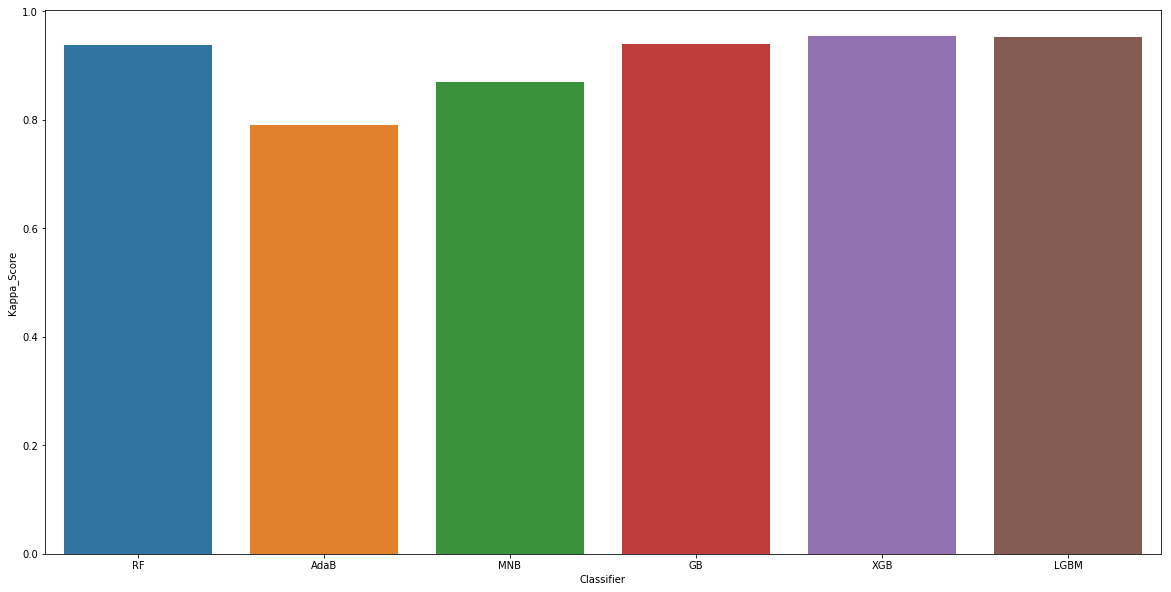

In [56]:
plt.figure(figsize=(20,10))
sns.barplot(x= 'Classifier', y= 'Kappa_Score', data= cmp)

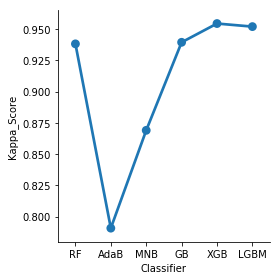

In [57]:
sns.factorplot(x= 'Classifier', y= 'Kappa_Score', data= cmp)

XGBoost Classifier is giving the highest kappa score of 0.9543. Hence we will use it for our final pipeline and API.

####  Final Pipeline

In [58]:
pipeline = Pipeline([  
    ('tfidf', TfidfVectorizer(min_df = 0)),  # integer counts to weighted TF-IDF scores
    ('classifier', XGBClassifier(n_estimators= 150, random_state = 1)),  # train on TF-IDF vectors w/ XGB classifier
])

####  Creating dataframe for Scores given by human grader and scores predicted by XGBC for testing dataset.

In [59]:
d = {'Actual': Test['score'], 'Predictions': predictions2}
df = pd.DataFrame(data = d)

In [60]:
df.head()

,Actual,Predictions
1545,8.0,8.0
1171,9.0,10.0
302,10.0,10.0
108,8.0,8.0
916,11.0,10.0


#### Let's visualize the distribution between Actual and Predicted  Values.

Visualization for first 50 rows of testing data.

Blue Line: Actual

Orange Line: Predictions

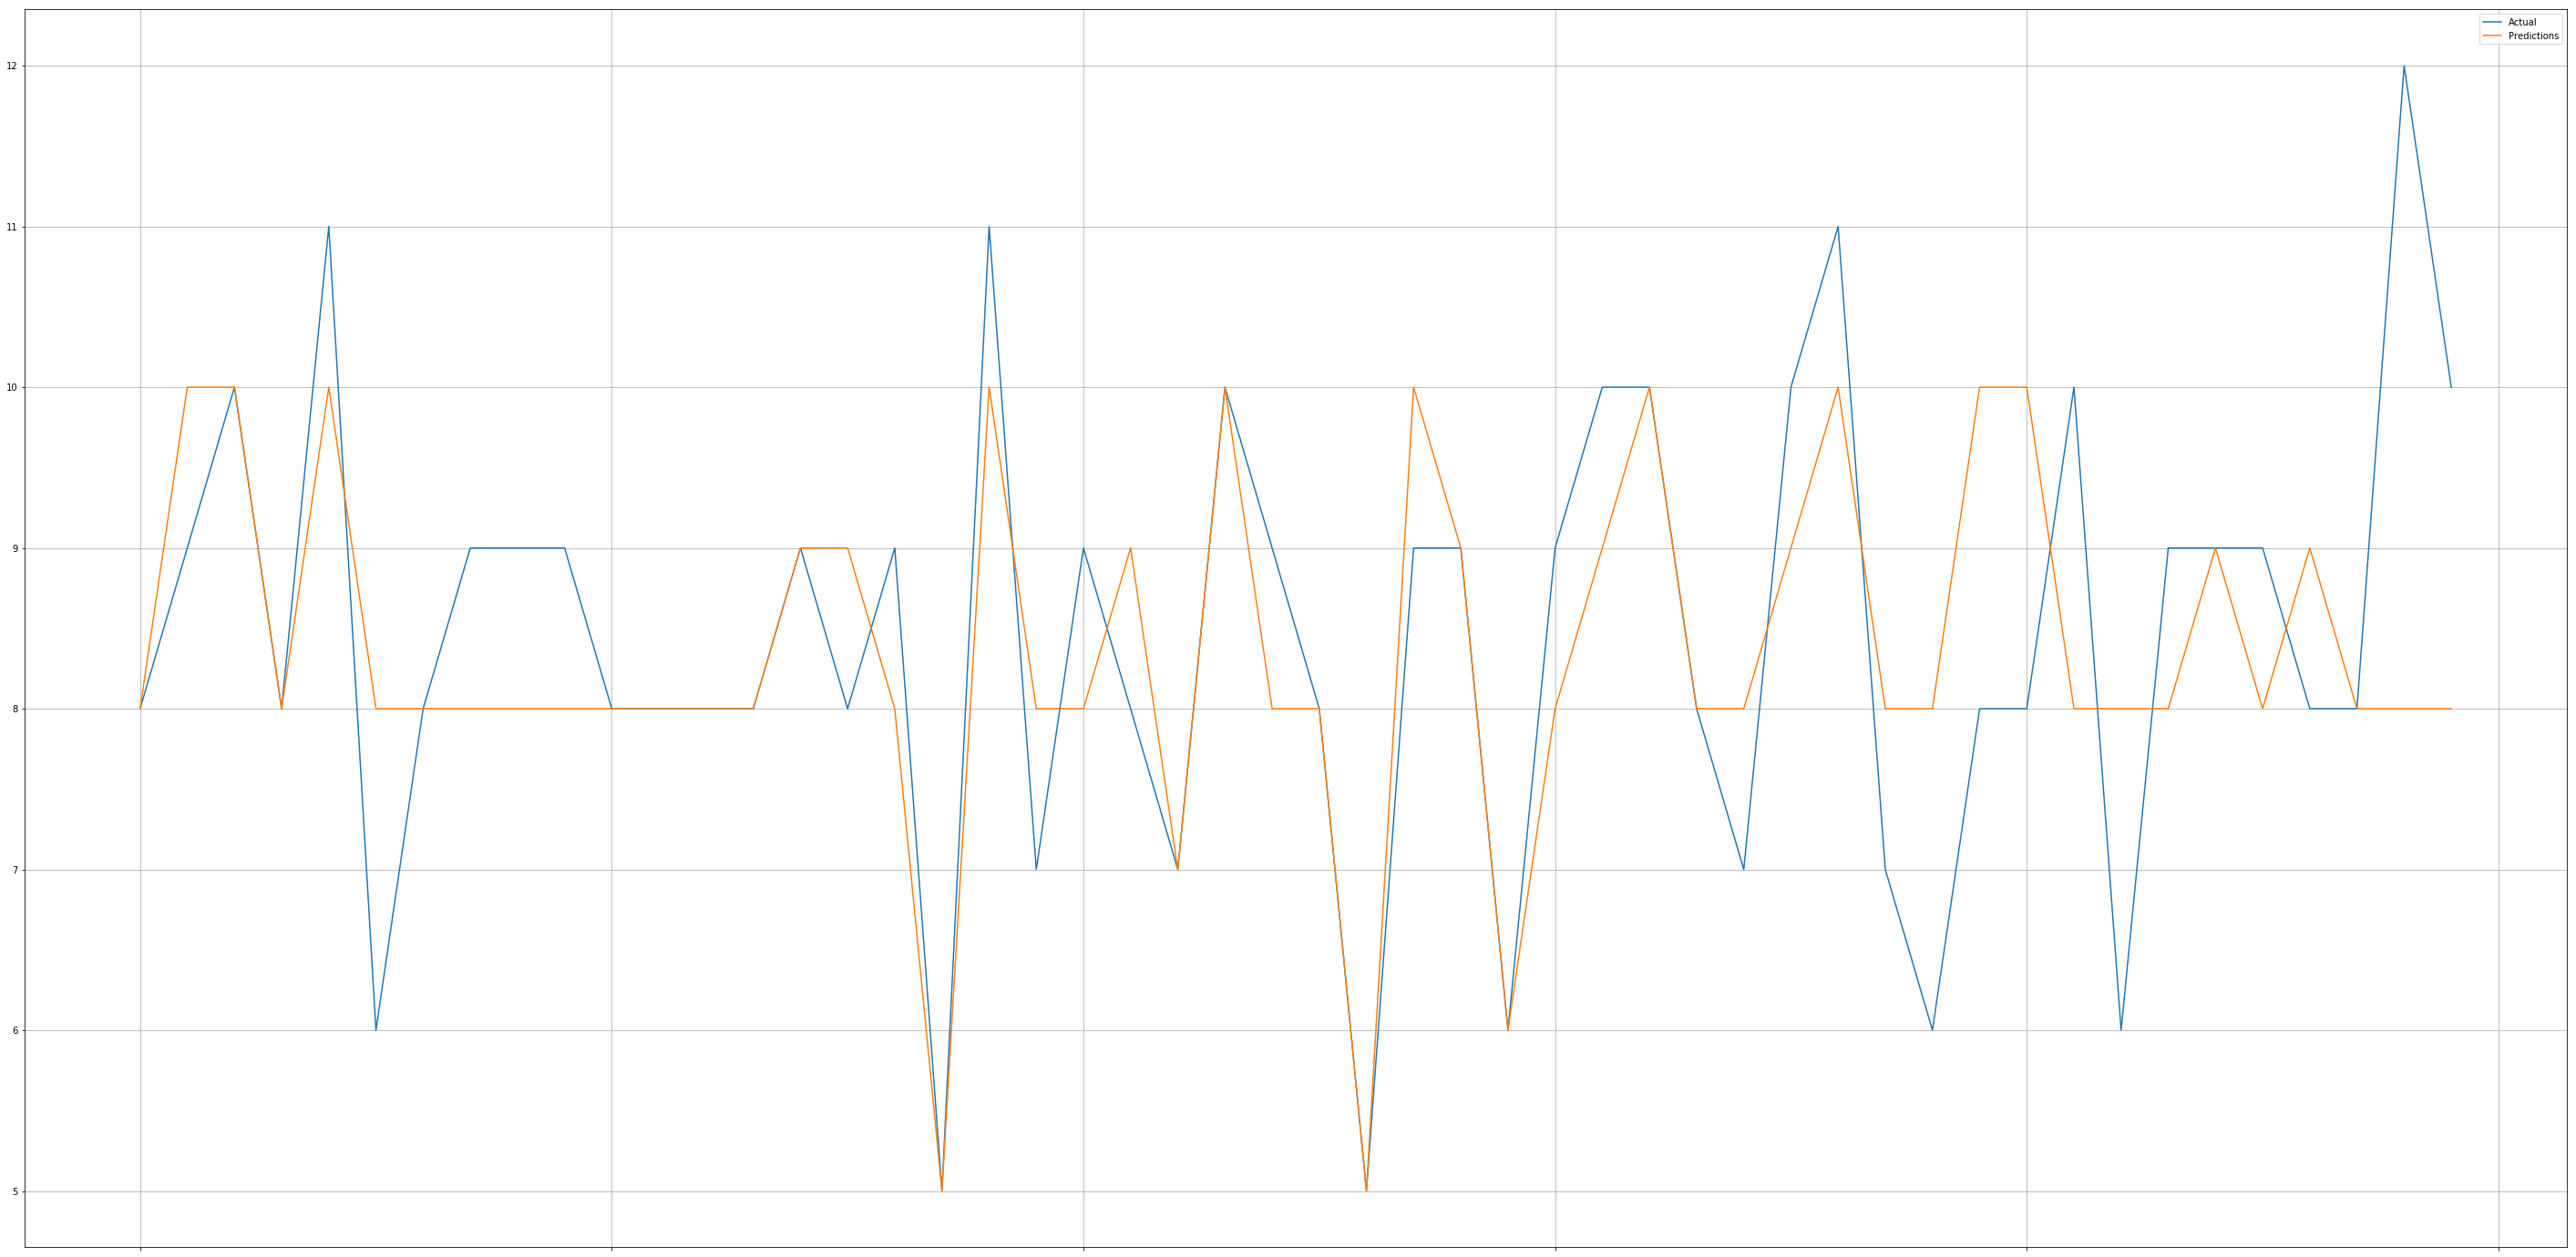

In [63]:
df[0:50].plot(y = ['Actual', 'Predictions'], figsize=(50, 25), grid=True)

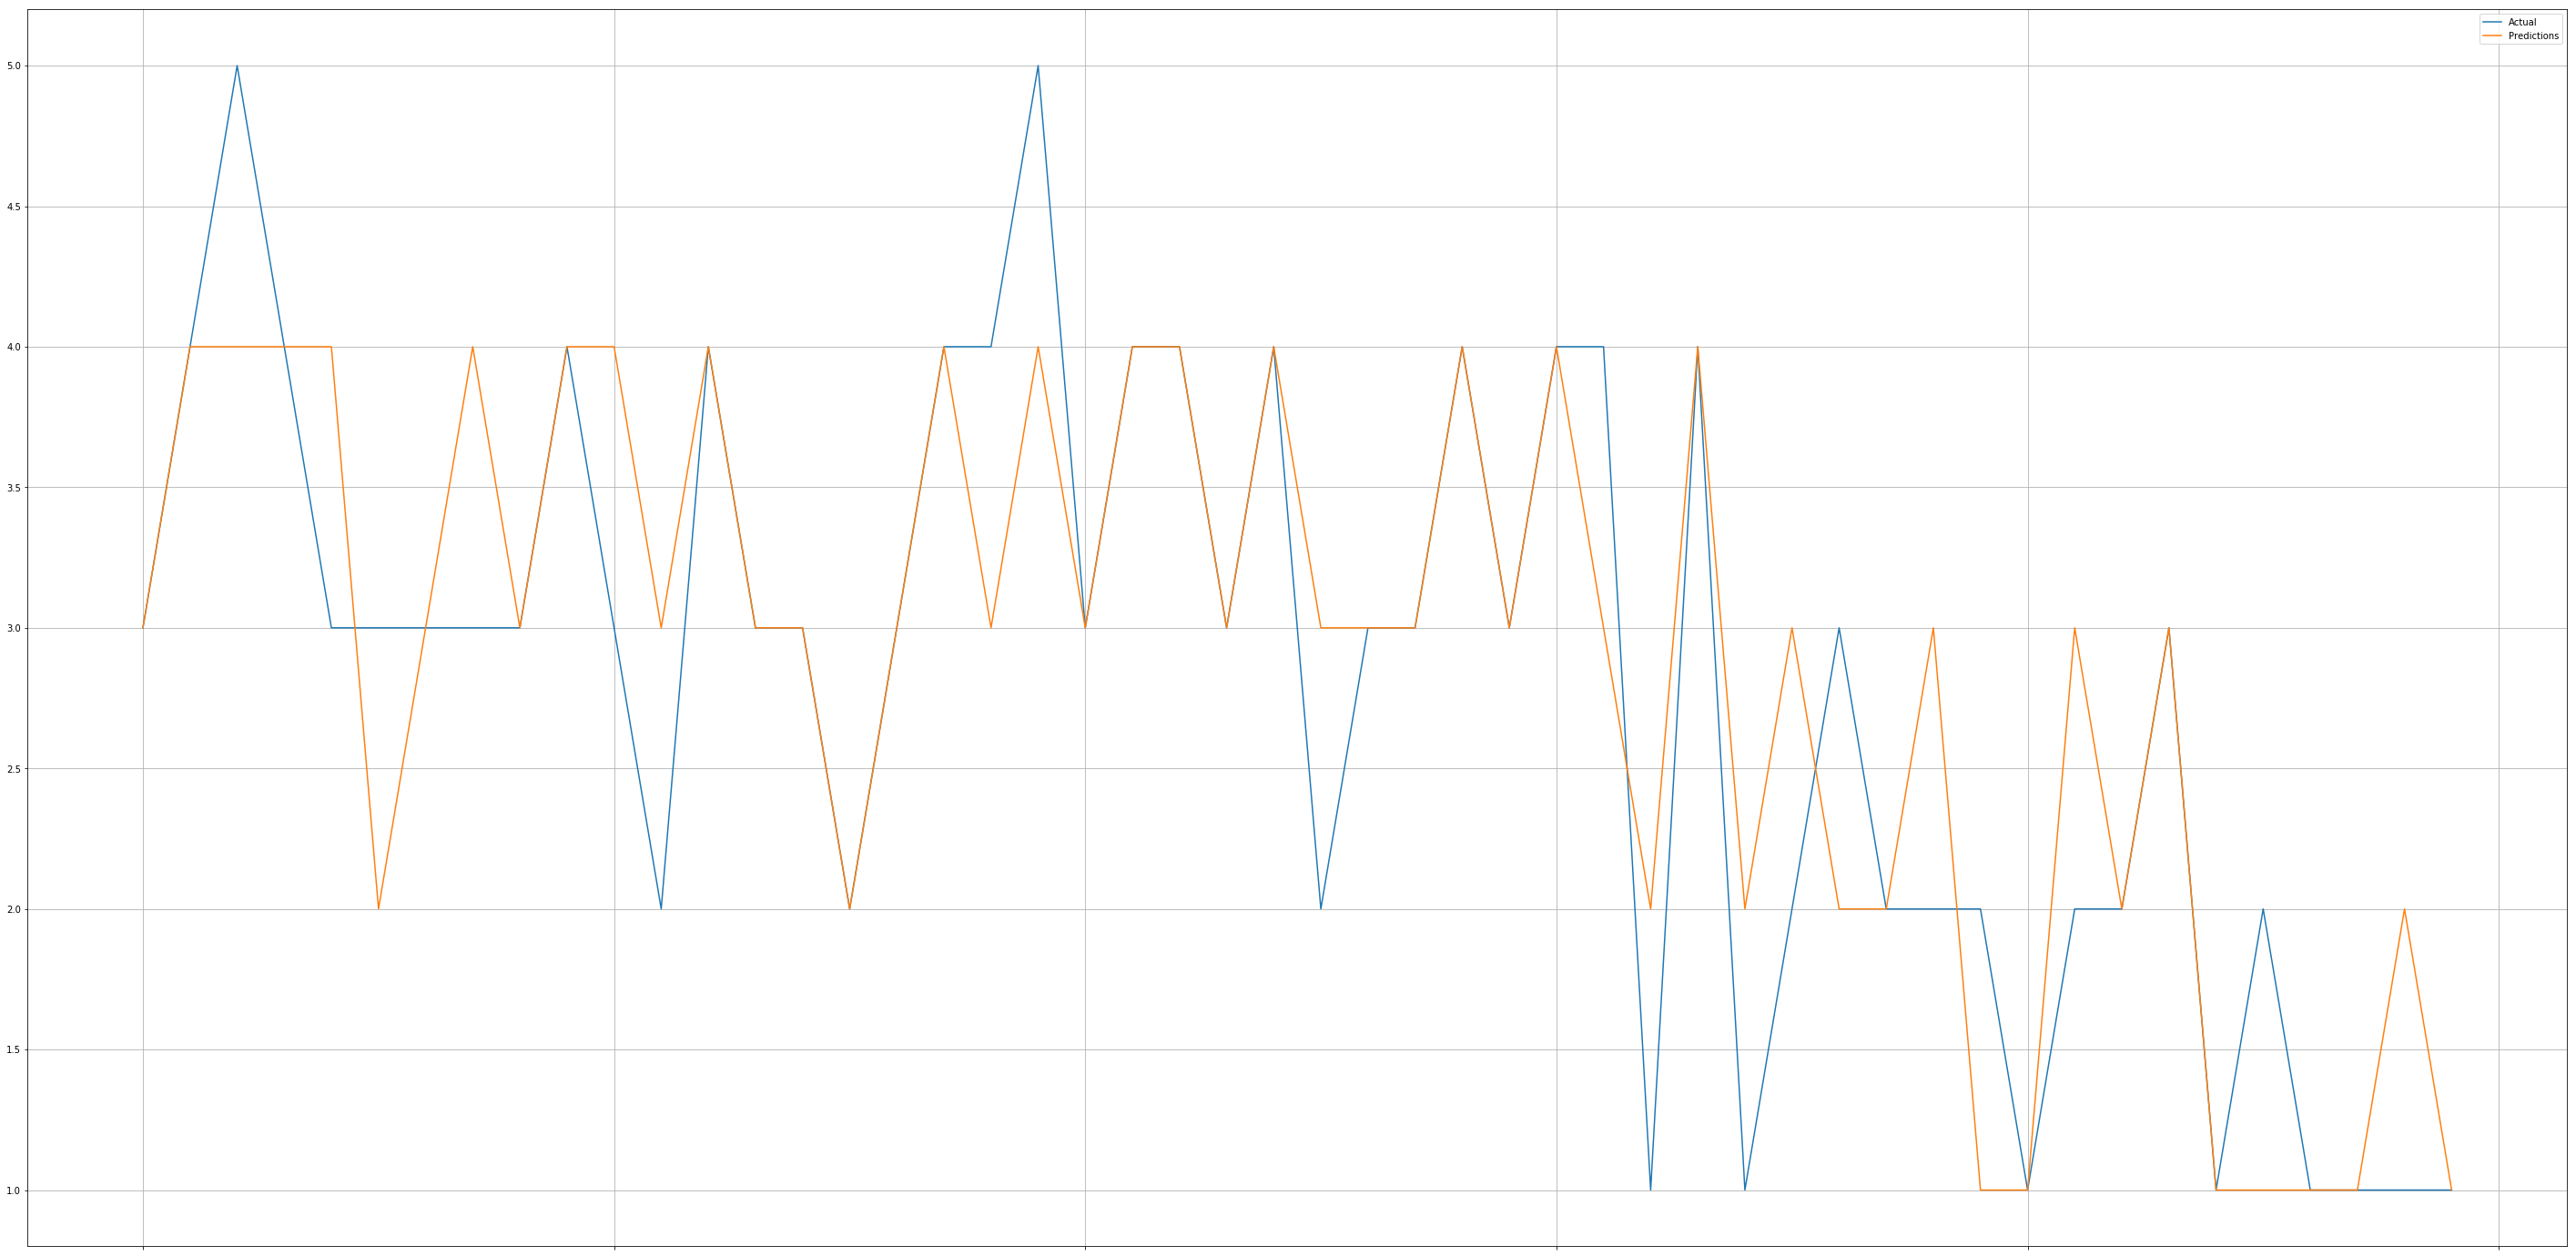

In [64]:
df[325:375].plot(y = ['Actual', 'Predictions'], figsize=(50, 25), grid=True)

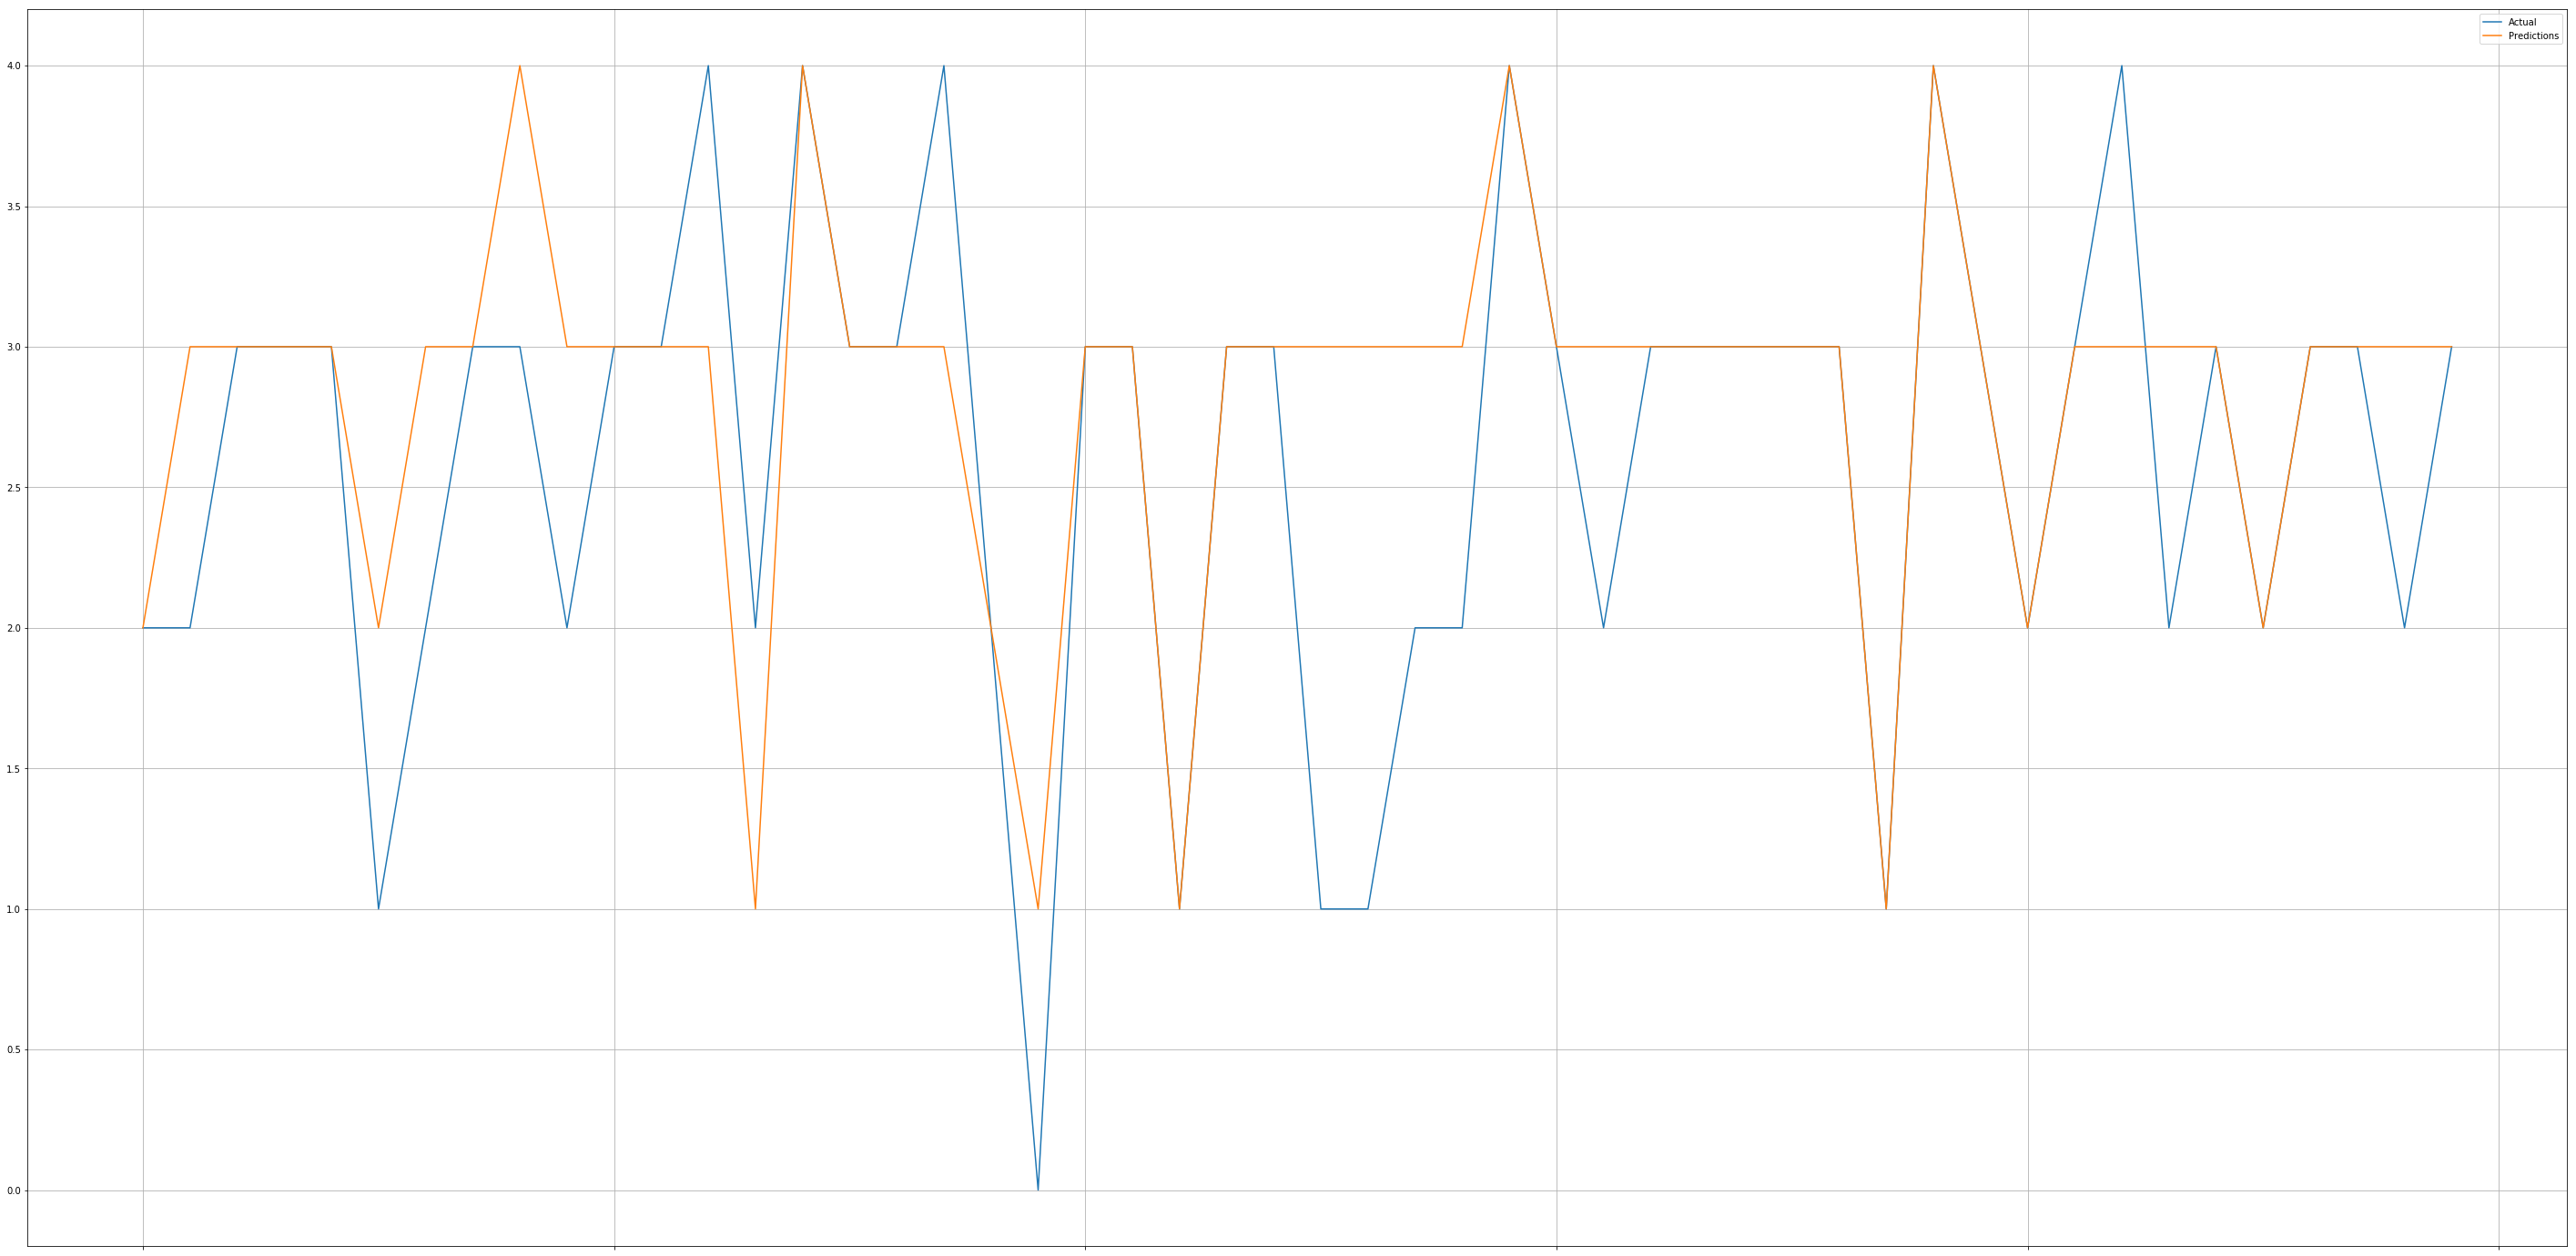

In [65]:
df[900:950].plot(y = ['Actual', 'Predictions'], figsize=(50, 25), grid=True)

In [66]:
writer = pd.ExcelWriter('XGBoost.xlsx')
df.to_excel(writer)
writer.save()

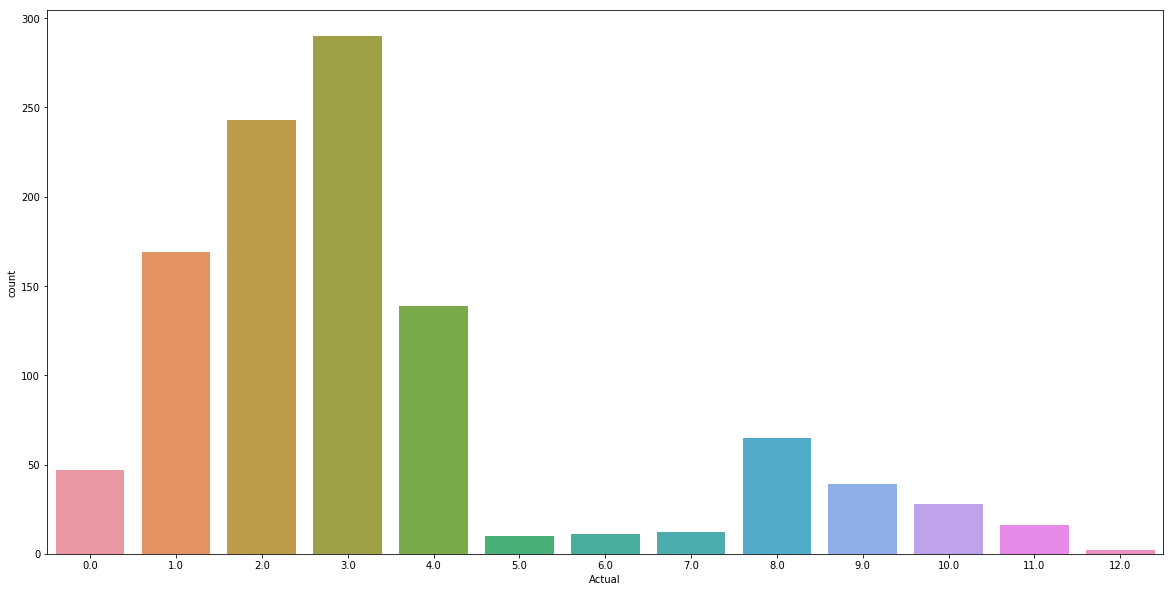

In [71]:
plt.figure(figsize=(20,10))
sns.countplot(x = 'Actual', data= df)

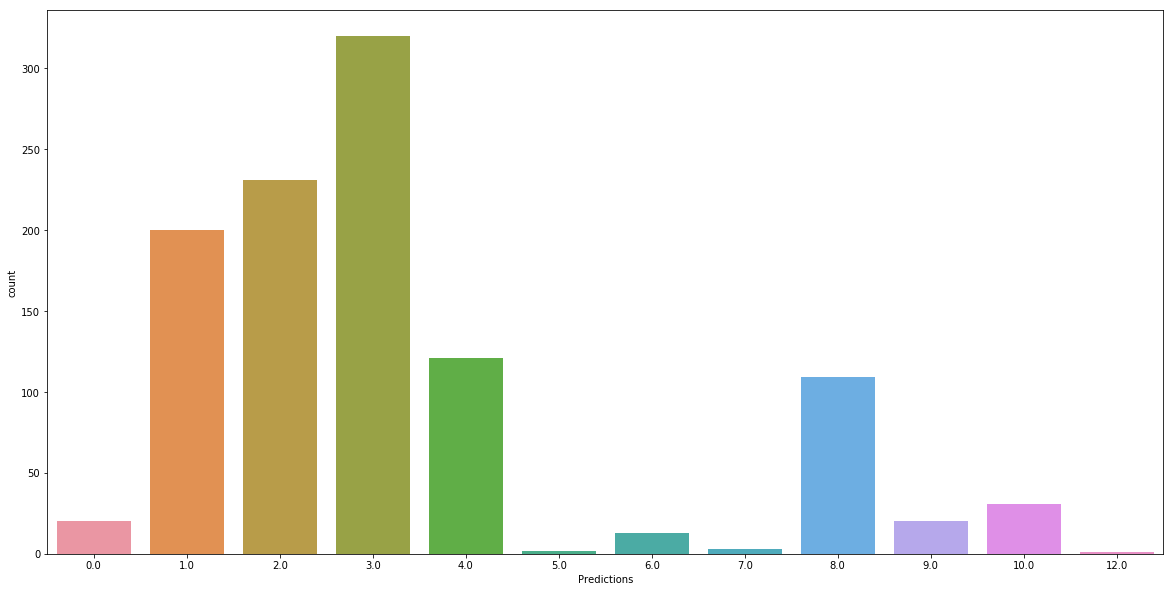

In [72]:
plt.figure(figsize=(20,10))
sns.countplot(x = 'Predictions', data= df)

![Actal v/s Predictions](XGBC.png)

Link for viewing the complete version of above visualization.

https://public.tableau.com/profile/aman.goel#!/vizhome/XGBClassifier2/Sheet1

![Circular Drive](XGBC1.png)

Link for viewing the complete version of above visualization.

https://public.tableau.com/profile/aman.goel#!/vizhome/XGBClassifier/Sheet1

## Using the built API for the Automated Essay Grader for Predicting Score on an essay and Re-Training the model when more data is added.

In [74]:
from sklearn.externals import joblib
import requests, json
import pickle

In [75]:
BASE_URL = "http://localhost:5000"

In [84]:
joblib.dump(pipeline2, "model.pkl")
joblib.dump(Train['essay'], "training_data.pkl")
joblib.dump(Train_score, "training_labels.pkl")

['training_labels.pkl']

## Performing Prediction

In [85]:
essay = {"essay":  [Test["essay"][0]]}
response = requests.post("{}/predict".format(BASE_URL), json = essay)

In [86]:
print("Predicted Score for the essay is {}".format((response.json())[0]))

Predicted Score for the essay is 8.0


## Performing Retraining

In [87]:
essays = ["I believe that computers have a positive effect on people. They help you stay in touch with family in a couple different ways they excercise your mind and hands and help you learn and make things easier. Computer's help you keep in touch with people. Say you live in @LOCATION1 and you miss your @CAPS1. You can just send an e-mail and talk all you want. If you don't just want to limit it to words you can add pictures so they can see how much you've grown or if you are well. Even if you're just e-mailing someone down the block it is just as effective as getting up and walking over there. You can also use a computer to make a scrap book card or slide show to show how much you love the person you give them to. Computers @MONTH1 not excercise you whole body but it excersises you mind and hands. You could play solitaire on the computer and come away @PERCENT1 smarter than before. You can play other games of strategy like checkers and chess while still sitting at home being comfortable. Your hands always play a big role while you're on the computer. They need to move the mouse and press the keys on a keyboard. Your hands learn all the keys from memorization. It's like the computer's teaching handi-coordination and studying habit for the future. Computers make human lives easier. Not only do they help kids turn in a nice neatly printed piece or paper for home work but they also help the average person. Teachers use it to keep peoples grades in order and others use it to write reports for various jobs. The @CAPS2 probably uses one to write a speech or to just keep his day in order. Computers make it easier to learn certain topics like the @LOCATION2 history. You can type something into a searcher site and have ton's of websites for one person with, who knows how much imformation. Instead of flipping through all the pages in a dictionary you can look for an online dictionary, type in the word and you have the definition. Computers have positive effects on people because they help you keep close to your family, they challenge your mind to be greater and excercise your hands and they make life easier for kids and the average person. This is why, I think computers have good effects on society.",
         "In the “Winter Hibiscus the author ends the story with “when they come back, Saeng vowed silently to herself, in the spring, when the snow melt and the geese return and this hibiscus is budding, then I will take the test again.“ I think he does this because then you see the strong relationship between Saeng and the Hibiscus. They both are out of there homeland and not as happy but they can still grow. So it’s almost as if Saeng is making a deal that when the plant finally buds she will finally take the test again."]
score = [7.0, 3.0]

Df = {'essay': essays, 'score': score}

Df = pd.DataFrame(data = Df)

In [88]:
Df

,essay,score
0,I believe that computers have a positive effec...,7.0
1,In the “Winter Hibiscus the author ends the st...,3.0


Preprocessing the texts in Df

In [89]:
preprocessing(Df)

In [90]:
Df['essay'][0]

'believe computers positive effect people help stay touch family couple different ways excercise mind hands help learn make things easier computers help keep touch people say live location1 miss caps1 send e mail talk want dont want limit words add pictures see much youve grown well even youre e mailing someone block effective getting walking also use computer make scrap book card slide show show much love person give computers month1 excercise whole body excersises mind hands could play solitaire computer come away percent1 smarter play games strategy like checkers chess still sitting home comfortable hands always play big role youre computer need move mouse press keys keyboard hands learn keys memorization like computers teaching handi coordination studying habit future computers make human lives easier help kids turn nice neatly printed piece paper home work also help average person teachers use keep peoples grades order others use write reports various jobs caps2 probably uses one 

In [91]:
Data = json.dumps([{"essay": Df['essay'][0], "score": Df['score'][0]}, 
                   {"essay": Df['essay'][1], "score": Df['score'][1]}
                  ])

Data

'[{"essay": "believe computers positive effect people help stay touch family couple different ways excercise mind hands help learn make things easier computers help keep touch people say live location1 miss caps1 send e mail talk want dont want limit words add pictures see much youve grown well even youre e mailing someone block effective getting walking also use computer make scrap book card slide show show much love person give computers month1 excercise whole body excersises mind hands could play solitaire computer come away percent1 smarter play games strategy like checkers chess still sitting home comfortable hands always play big role youre computer need move mouse press keys keyboard hands learn keys memorization like computers teaching handi coordination studying habit future computers make human lives easier help kids turn nice neatly printed piece paper home work also help average person teachers use keep peoples grades order others use write reports various jobs caps2 probab

In [93]:
response = requests.post("{}/retrain".format(BASE_URL), json = Data)

In [94]:
print("Outcome of Re Training : {}".format(response.json()))

Outcome of Re Training : Retrained model successfully.
